See [circular_exp_fitting](circular_exp_fitting.ipynb)  and  [sersic_integral_experiments](sersic_integral_experiments.ipynb) for prior art

In [1]:
import multiprocessing
multiprocessing.set_start_method('fork')

In [2]:
import numpy as np
np.seterr(invalid='ignore') # cleans up the warning junk in nans

from scipy import special

import sympy

import regions
from regions import CirclePixelRegion, PixCoord, RectanglePixelRegion, CirclePixelRegion, PolygonPixelRegion

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
TWOPI = 2*np.pi
ICOEFFS = [2, -1/3, 4/405, 46/25515, 131/1148175, -2194697/30690717750]

def f_bn(n):
    """
    Ciotti and Bertin 99, valid for n >~ 0.36
    """
    return np.sum([C*n**(1-i) for i, C in enumerate(ICOEFFS)], axis=0)

def sersic_profile(R, Ie, Re, n):
    bn = f_bn(n)
    return Ie * np.exp(-bn*((R/Re)**(1/n)-1))

def log_sersic_profile(R, Ie, Re, n):
    bn = f_bn(n)
    return np.log(Ie) - bn*((R/Re)**(1/n)-1)

Informational plot on the profiles compared to plummer

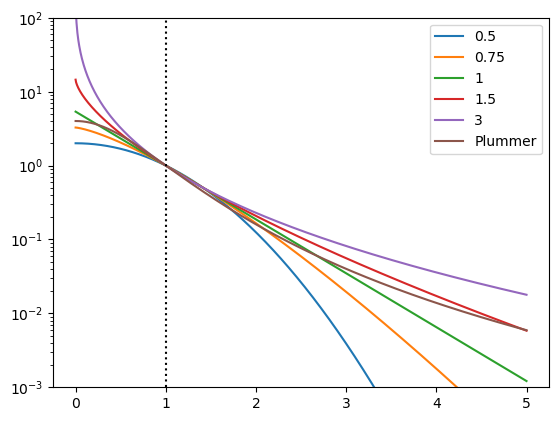

In [5]:
rs = np.linspace(0, 5, 1000)
for n in [.5, .75,1, 1.5, 3]:
    plt.plot(rs, sersic_profile(rs, Ie=1, Re=1, n=n), label=str(n))
def p(r, a=1):
    return a**2*(a**2 + r**2)**-2 / np.pi
A = p(1)
plt.plot(rs, p(rs)/A, label='Plummer')
plt.semilogy()
plt.legend(loc=0)
plt.ylim(1e-3, 100)
plt.axvline(1, c='k', ls=':');

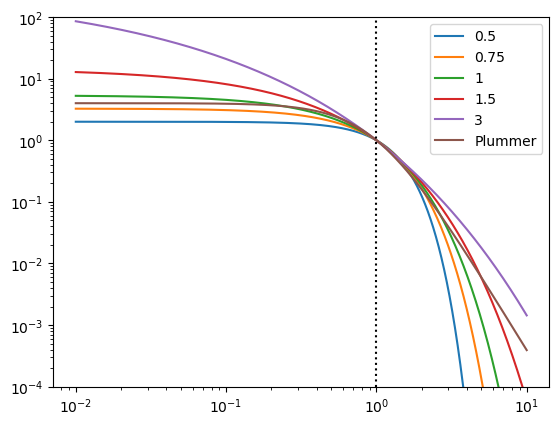

In [6]:
rs = np.logspace(-2, 1, 1000)
for n in [.5, .75,1, 1.5, 3]:
    plt.plot(rs, sersic_profile(rs, Ie=1, Re=1, n=n), label=str(n))
def p(r, a=1):
    return a**2*(a**2 + r**2)**-2 / np.pi
A = p(1)
plt.plot(rs, p(rs)/A, label='Plummer')
plt.loglog()
plt.legend(loc=0)
plt.ylim(1e-4, 100)
plt.axvline(1, c='k', ls=':');

In practice, plummer is in the range n~1 - 1.5, which justifies our choice of that as a fiducial range.

Now implement technique 5 for the sersic integral from sersic_integral_experiments

In [7]:
def make_grid_Iweighted(nr, nphi, outerr, Re, n):
    bn_val = f_bn(n)

    gamma2 = special.gammainc(2*n, outerr**(1/n) * Re**(-1/n) * bn_val)

    u = np.linspace(0, 1, nr)
    r = Re * (special.gammaincinv(2*n, u * gamma2) / bn_val)**n
    phi = np.linspace(0, 2*np.pi, nphi+1)[:-1]

    return np.meshgrid(r, phi)

def sersic_outer_integral(Router, Re, n):
    bnval = f_bn(n)
    numer1 = 4 * np.pi * Re * Re * bnval**(-2*n) * n*n * np.exp(bnval)
    
    # non-trivial thing here: the scipy gammainc is a *regularized* gamma function meaning it has a factor of 1/gamma(s), 
    # so we square our prefactor to have scipy's gammainc match the sympy definition which is not regularized
    numer2 = special.gamma(2*n)**2 * special.gammainc(2*n, Router**(1/n) * Re**(-1/n) * bnval)
    
    denom = special.gamma(2*n + 1)

    return numer1 * numer2 / denom

def sersic_integral(Re, n, region, x0=0, y0=0, nr=100, nphi=100):
    """
    Note the the region, Re, x0, and y0 should all be in pixels
    """

    outerr = np.max(np.abs(region.bounding_box.extent))
    outer_integ = sersic_outer_integral(outerr, Re, n)

    r, phi = make_grid_Iweighted(nr, nphi, outerr, Re, n)
    xg = r*np.cos(phi) + x0
    yg = r*np.sin(phi) + y0
    msk = region.contains(regions.PixCoord(x=xg, y=yg))

    frac_in_grid = np.sum(msk)/msk.size

    return outer_integ * frac_in_grid

Not clear if we should be sampling from the areal sersic function or the sersic function itself.  Fortunately they are very similar:

In [8]:
R, Ie, Re, n, bn, R1 = sympy.symbols('R, I_e, R_e, n, b_n, R_1', real=True, positive=True)
sersic = Ie * sympy.exp(-bn*((R/Re)**(1/n)-1))

R1, R2 = sympy.symbols('R1, R2', real=True, positive=True)
normalized_integral = sympy.simplify(sympy.integrate(sersic, (R,0, R1)) / sympy.integrate(sersic, (R,0, R2)))
normalized_integral

lowergamma(n, R1**(1/n)*b_n/R_e**(1/n))/lowergamma(n, R2**(1/n)*b_n/R_e**(1/n))

Which is the same as areal except it's $n$ instead of $2n$

In [9]:
def get_sersic_r(npoints, outerr, Re, n, rstate=np.random.default_rng(), areal=True):
    bn_val = f_bn(n)

    gammaparam = 2*n if areal else n

    gamma2 = special.gammainc(gammaparam, outerr**(1/n) * Re**(-1/n) * bn_val)

    u = rstate.uniform(size=npoints)
    r = Re * (special.gammaincinv(gammaparam, u * gamma2) / bn_val)**n

    return r

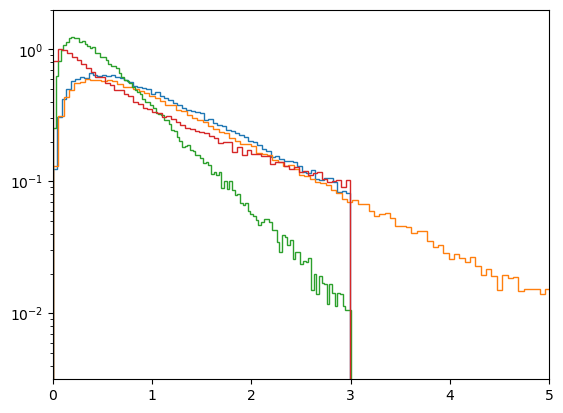

In [10]:

plt.hist(get_sersic_r(100000, 3, 1, 1.5, areal=True), bins='auto', histtype='step', density=True, log=True)
plt.hist(get_sersic_r(100000, np.inf, 1, 1.5, areal=True), bins='auto', histtype='step', density=True, log=True)
plt.hist(get_sersic_r(100000, 3, .5, 1.5, areal=True), bins='auto', histtype='step', density=True, log=True)
plt.hist(get_sersic_r(100000, 3, 1, 4., areal=True), bins='auto', histtype='step', density=True, log=True)
plt.xlim(0, 5);
plt.ylim(10**-2.5, 2);

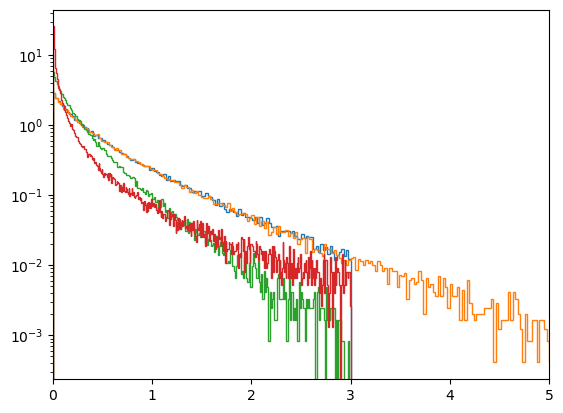

In [11]:
plt.hist(get_sersic_r(100000, 3, 1, 1.5, areal=False), bins='auto', histtype='step', density=True, log=True)
plt.hist(get_sersic_r(100000, np.inf, 1, 1.5, areal=False), bins='auto', histtype='step', density=True, log=True)
plt.hist(get_sersic_r(100000, 3, .5, 1.5, areal=False), bins='auto', histtype='step', density=True, log=True)
plt.hist(get_sersic_r(100000, 3, 1, 4., areal=False), bins='auto', histtype='step', density=True, log=True)
plt.xlim(0, 5);

After some though, it's definitely the areal one, which is clear from comparing them in the case where the Re is >> the survey volume - in that case it should be effectively uniform:

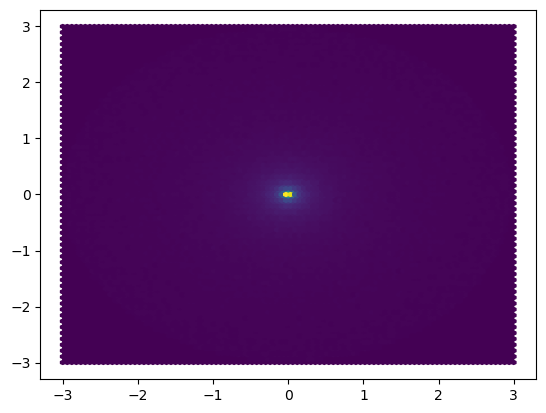

In [12]:
r = get_sersic_r(1000000, 3, 1000, 1.5, areal=False)
phi = np.random.rand(r.size)*2*np.pi
x = r*np.cos(phi)
y = r*np.sin(phi)

plt.hexbin(x, y);

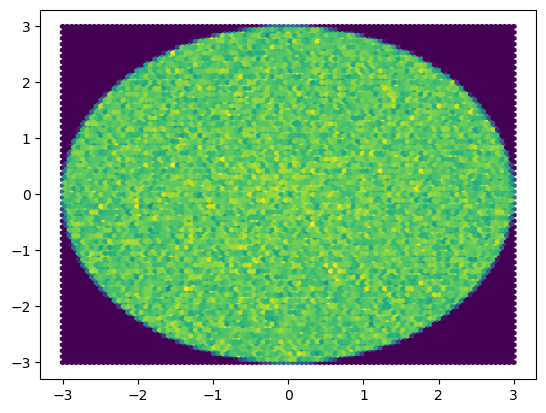

In [13]:
r = get_sersic_r(1000000, 3, 1000, 1.5, areal=True)
phi = np.random.rand(r.size)*2*np.pi
x = r*np.cos(phi)
y = r*np.sin(phi)

plt.hexbin(x, y);

Now define the generator functions:

In [14]:
def generate_unif_box(n=None, halfsize=1, density=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        A = (halfsize*2)**2
        n = density * A
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    x = rstate.uniform(-halfsize, halfsize, n)
    y = rstate.uniform(-halfsize, halfsize, n)

    return x, y

def uniform_in_region(density, region, rstate=np.random.RandomState()):
    maxpx = np.max(region.bounding_box.extent)
    xs, ys = generate_unif_box(halfsize=maxpx, density=density, rstate=rstate)
    msk = region.contains(PixCoord(xs, ys))

    return xs[msk], ys[msk]
    
def generate_sersic_dglx(n=None, Re=1, nsersic=1.5, density=None, region=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        # density is the mean density within the HLR
        hA = np.pi*Re**2
        n = 2 * density * hA
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    r = get_sersic_r(n, np.inf, Re, nsersic, rstate, areal=True)
    phi = rstate.uniform(0, 2*np.pi, n)

    x = np.cos(phi)*r
    y = np.sin(phi)*r

    if region is not None:
        msk = region.contains(PixCoord(x, y))
        x = x[msk]
        y = y[msk]

    return x, y

def glx_and_uniform(glx_hdensity, bkg_density, region, Re=1, nsersic=1.25, rstate=np.random.RandomState()):
    g = generate_sersic_dglx(density=glx_hdensity, Re=Re, nsersic=nsersic, region=region, rstate=rstate)
    b = uniform_in_region(bkg_density, region=region, rstate=rstate)

    return np.concatenate((g, b), axis=1), g, b

(627, 513)

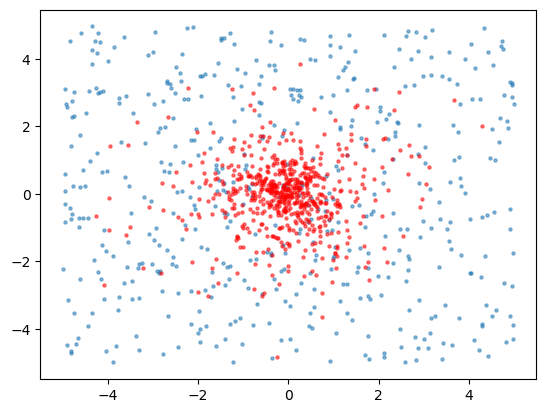

In [15]:
test_region = RectanglePixelRegion(PixCoord(0, 0), 10, 10)
_, g, b = glx_and_uniform(100, 5, test_region, Re=1, nsersic=1.25)
plt.scatter(b[0],b[1], s=5, alpha=.5)
plt.scatter(g[0],g[1], s=5, alpha=.5, c='r')
len(g[0]), len(b[0])

In [16]:
circular_large_reg = CirclePixelRegion(PixCoord(0, 0), 10)
circular_small_reg = CirclePixelRegion(PixCoord(0, 0), 3)
rectangular_large_reg = RectanglePixelRegion(PixCoord(0, 0), 20, 20)
rectangular_small_reg = RectanglePixelRegion(PixCoord(0, 0), 6, 6)

offset_region1 = RectanglePixelRegion(PixCoord(2, 3), 2, 3)
offset_region2 = RectanglePixelRegion(PixCoord(0, -1), 6, 6)
offset_regions = offset_region1 | offset_region2

offset_poly_region = PolygonPixelRegion(PixCoord([-3, -3, 3, 3, 1, 1, -3], [2, -4, -4, 5, 5, 3, 2]))

all_regions = {nm: globals()[nm] for nm in 'circular_large_reg,circular_small_reg,rectangular_large_reg,rectangular_small_reg,offset_poly_region'.split(',')}

# Set up fitting code

`region` is a fixed region - if None the integrals are implied to infity.

Parameters:
* x0, y0 -> center
* Re -> half-light radius
* n -> sersic parameter
* fbkg -> background fraction of all the stars

In [17]:
import dynesty
from dynesty import plotting as dyplot

param_names = 'x0, y0, Re, n, fbkg'.split(', ')

Derive the bounded scale-free prior generator

In [18]:
σ, x, a, b, A, F = sympy.symbols('σ,x,a,b,A,F', real=True, positive=True)
Asoln = sympy.solve(sympy.integrate(A/σ,(σ,a,b)) - 1, A)[0]
sympy.solve(sympy.integrate(A/σ,(σ,a,x)).subs(A, Asoln) - F, x)[0]

a**(1 - F)*b**F

Prior below is that x0, y0 are on U[-1, 1], Re is scale-free on [.01, 100], n is U[1, 1.5], fbkg is U[.1, .9]

In [45]:
uppri = 100
lpri = .01

def prior_transform(u):
    x = np.empty_like(u)
    x[:2] = u[:2]*2 -1
    x[2] = lpri**(1-u[2]) * uppri**u[2]
    x[3] = u[3]*.5 + 1.
    x[4] = u[4]*.8 + .1

    return x

In [51]:
test_region = circular_large_reg
test_data, tg, tb = glx_and_uniform(50, 2, test_region, nsersic=1.25, Re=1)
truths = [0, 0, 1, 1.25, -1]

truths[-1] = len(tb[0])/(len(tb[0]) + len(tg[0]))

len(tg[0]), len(tb[0]), truths[-1]

(314, 626, 0.6659574468085107)

In [52]:
LTWOPI = np.log(TWOPI)

def loglike(p, data, region):
    x0, y0, Re, n, fbkg = p
    x, y = data

    r = np.hypot(x-x0, y-y0)
    lgal = log_sersic_profile(r, 1, Re, n) - np.log(sersic_integral(Re, n, region=region, x0=x0, y0=y0, nr=500, nphi=100)) + LTWOPI 
    lfbkg = np.log(fbkg/region.area) + LTWOPI
    ll = np.logaddexp(lgal + np.log(1-fbkg), lfbkg)

    return np.sum(ll)
    

In [53]:
with dynesty.pool.Pool(multiprocessing.cpu_count(), loglike, prior_transform,
                                logl_kwargs={'data': test_data, 'region':test_region},
                      ) as pool:
    dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                            ndim=len(param_names),sample='rslice')
    dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})

0it [00:00, ?it/s]/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var

On newish mac w/ Apple M2 Max: 

16024it [01:01, 262.29it/s, batch: 4 | bound: 13 | nc: 1 | ncall: 585493 | eff(%):  2.643 | loglstar: -2878.203 < -2871.594 < -2873.149 | logz: -2885.425 +/-  0.114 | stop:  0.936]      


/Users/etollerud/src/structparams_inference_biases/.pixi/envs/default/lib/python3.12/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


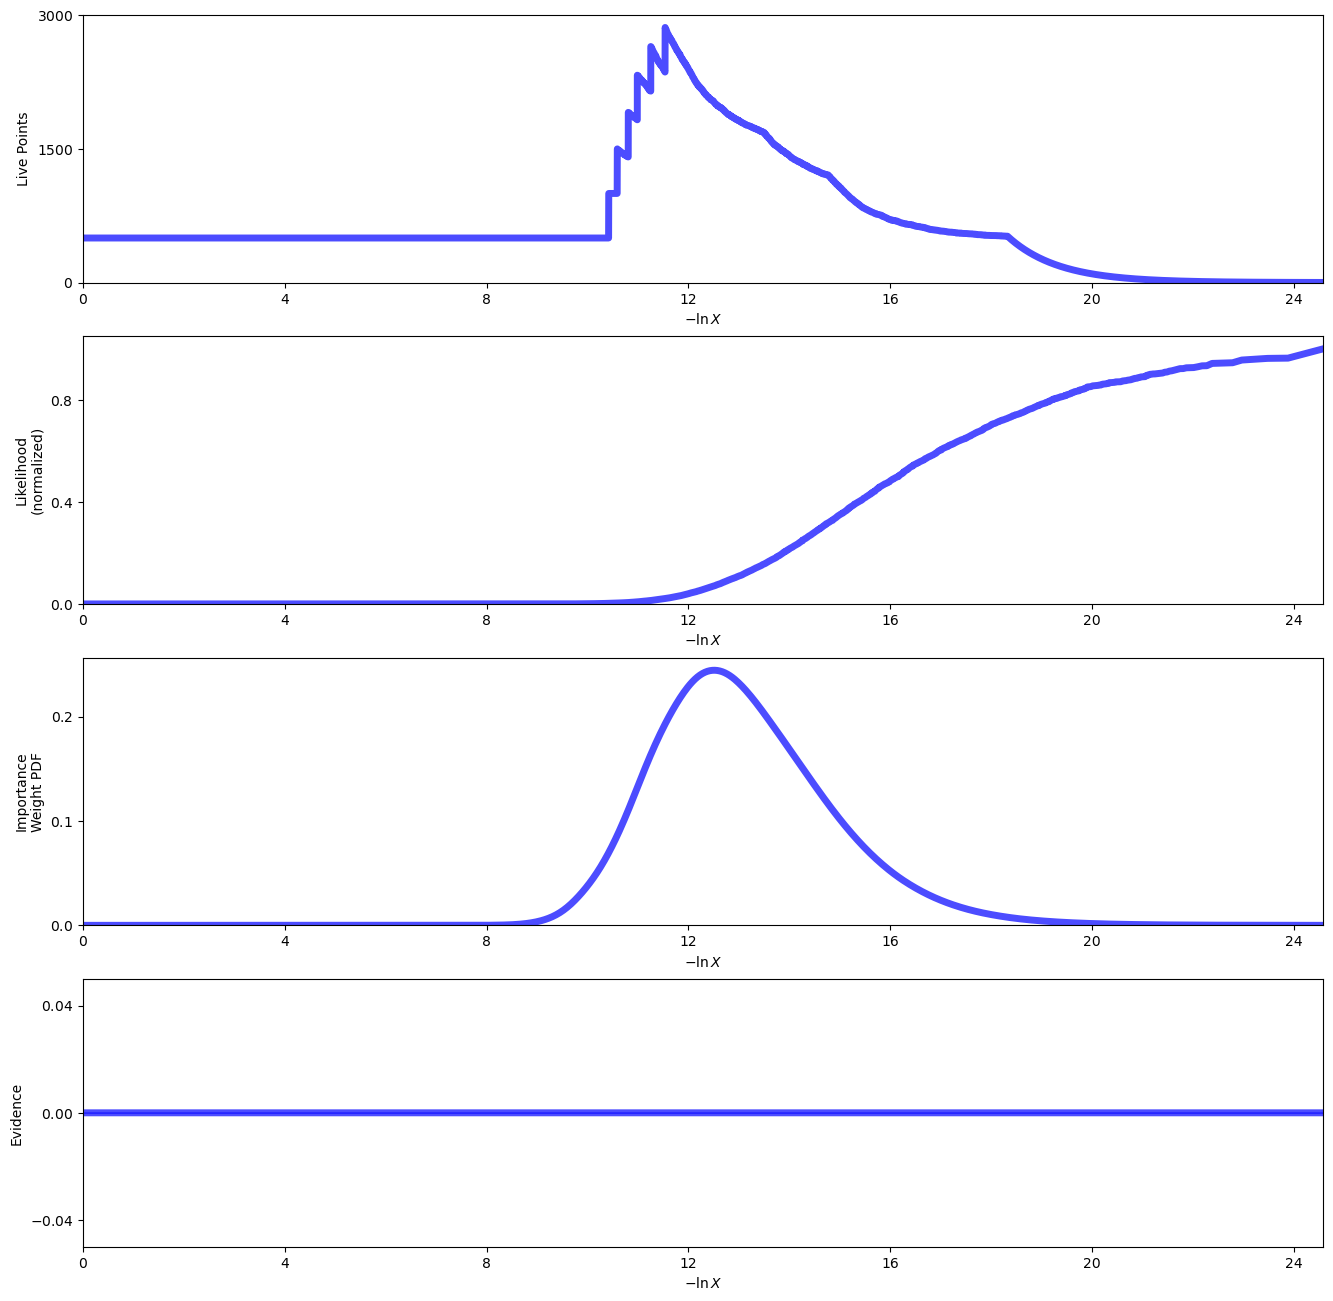

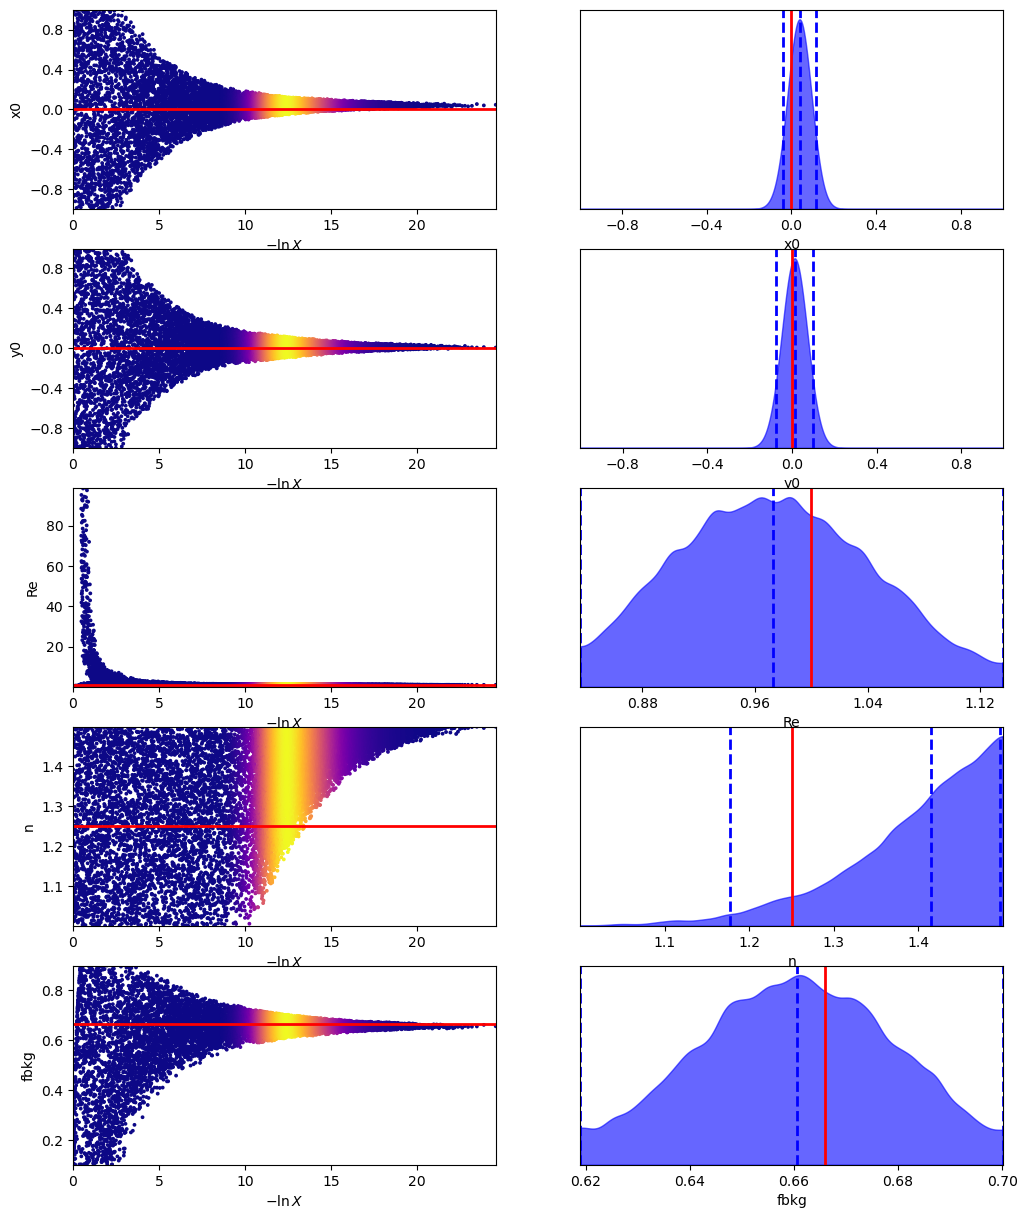

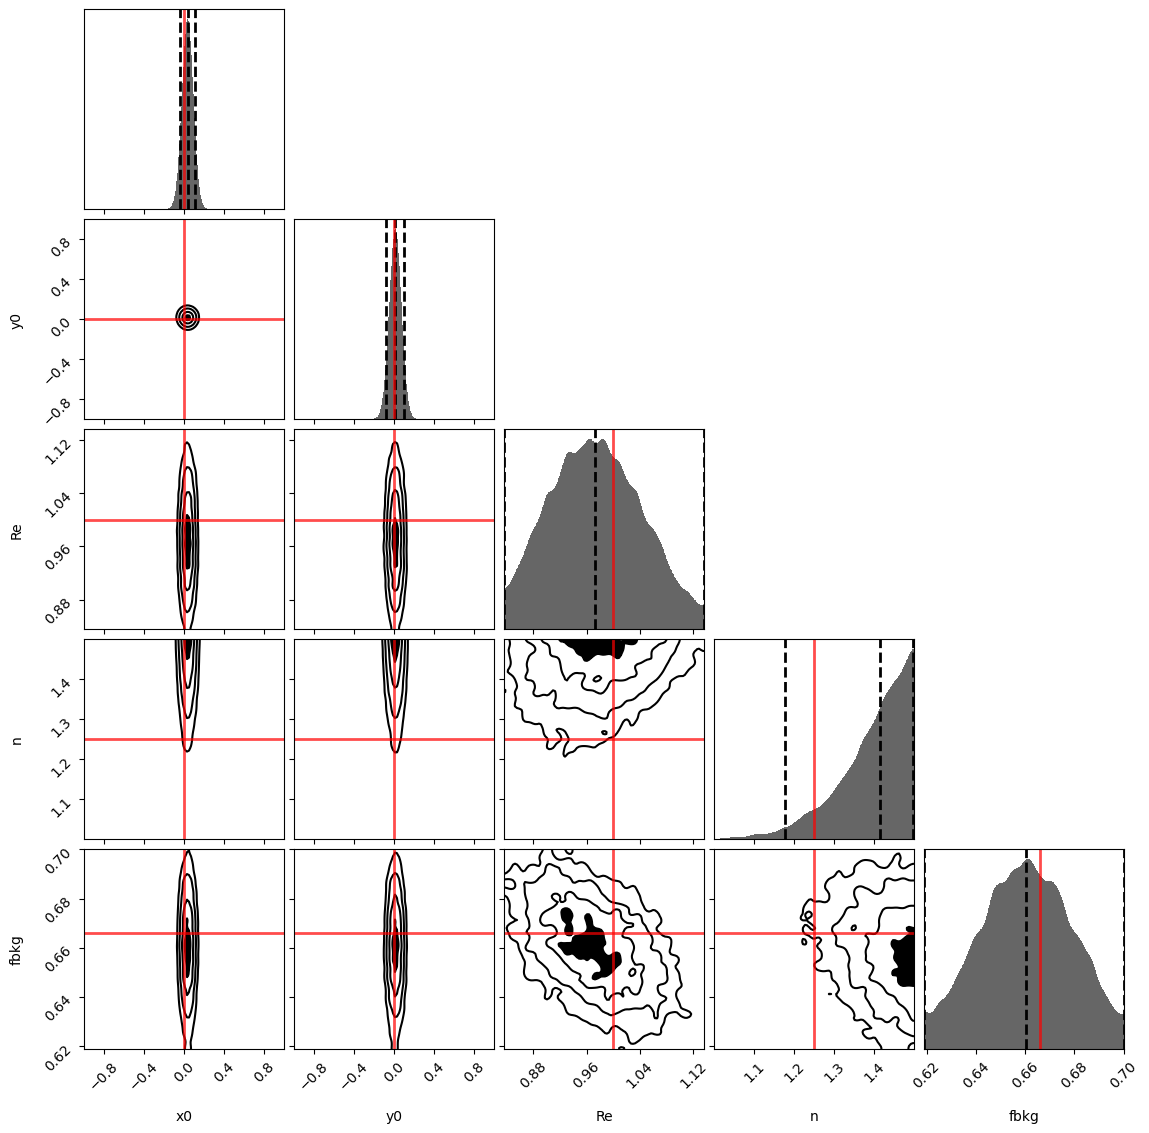

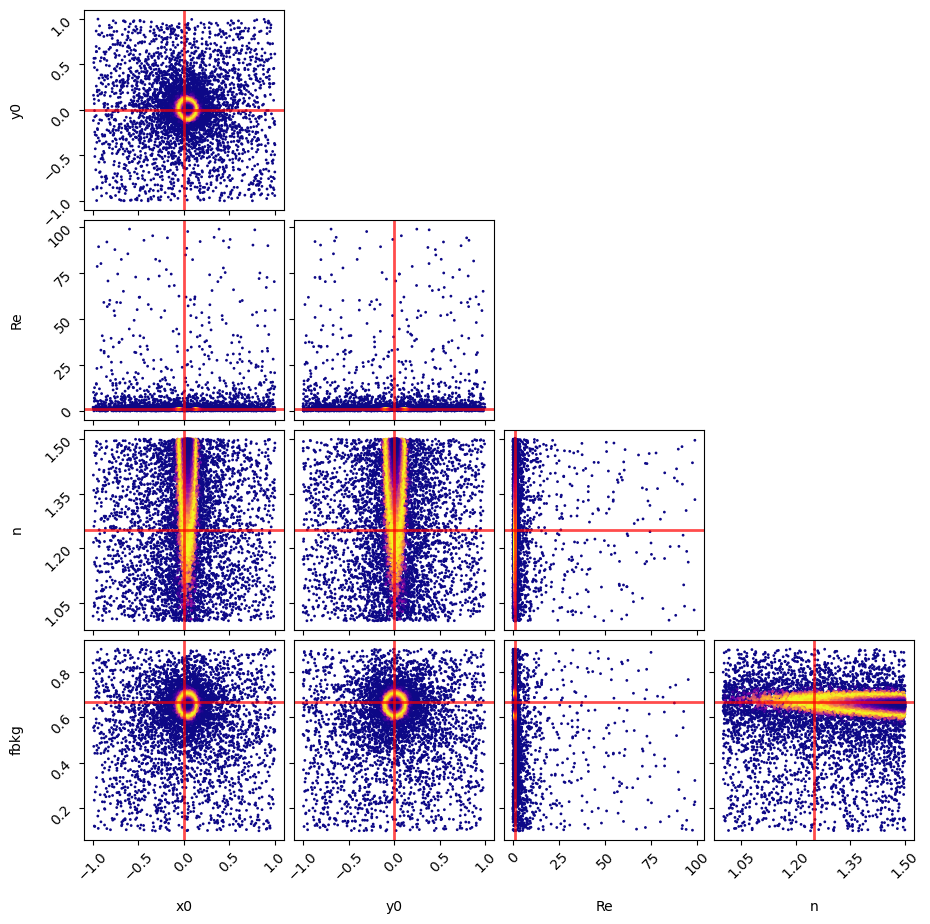

In [54]:
fig, axes = dyplot.runplot(dsampler.results)

span = [1,1, .95, 1, .95]

fig, axes = dyplot.traceplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerpoints(dsampler.results, labels=param_names, truths=truths)

Now as a test exercise... can we rule out an exponential?

In [56]:
LTWOPI = np.log(TWOPI)

def loglike_nfixed(p, data, region):
    x0, y0, Re, n, fbkg = p
    n = 1
    x, y = data

    r = np.hypot(x-x0, y-y0)
    lgal = log_sersic_profile(r, 1, Re, n) - np.log(sersic_integral(Re, n, region=region, x0=x0, y0=y0, nr=500, nphi=100)) + LTWOPI 
    lfbkg = np.log(fbkg/region.area) + LTWOPI
    ll = np.logaddexp(lgal + np.log(1-fbkg), lfbkg)

    return np.sum(ll)
    

In [57]:
with dynesty.pool.Pool(multiprocessing.cpu_count(), loglike_nfixed, prior_transform,
                                logl_kwargs={'data': test_data, 'region':test_region},
                      ) as pool:
    dsampler2 = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                            ndim=len(param_names),sample='rslice')
    dsampler2.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})

0it [00:00, ?it/s]/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_31427/3627158915.py:34: RuntimeWarning: invalid value encountered in multiply
  yg = r*np.sin(phi) + y0
/var

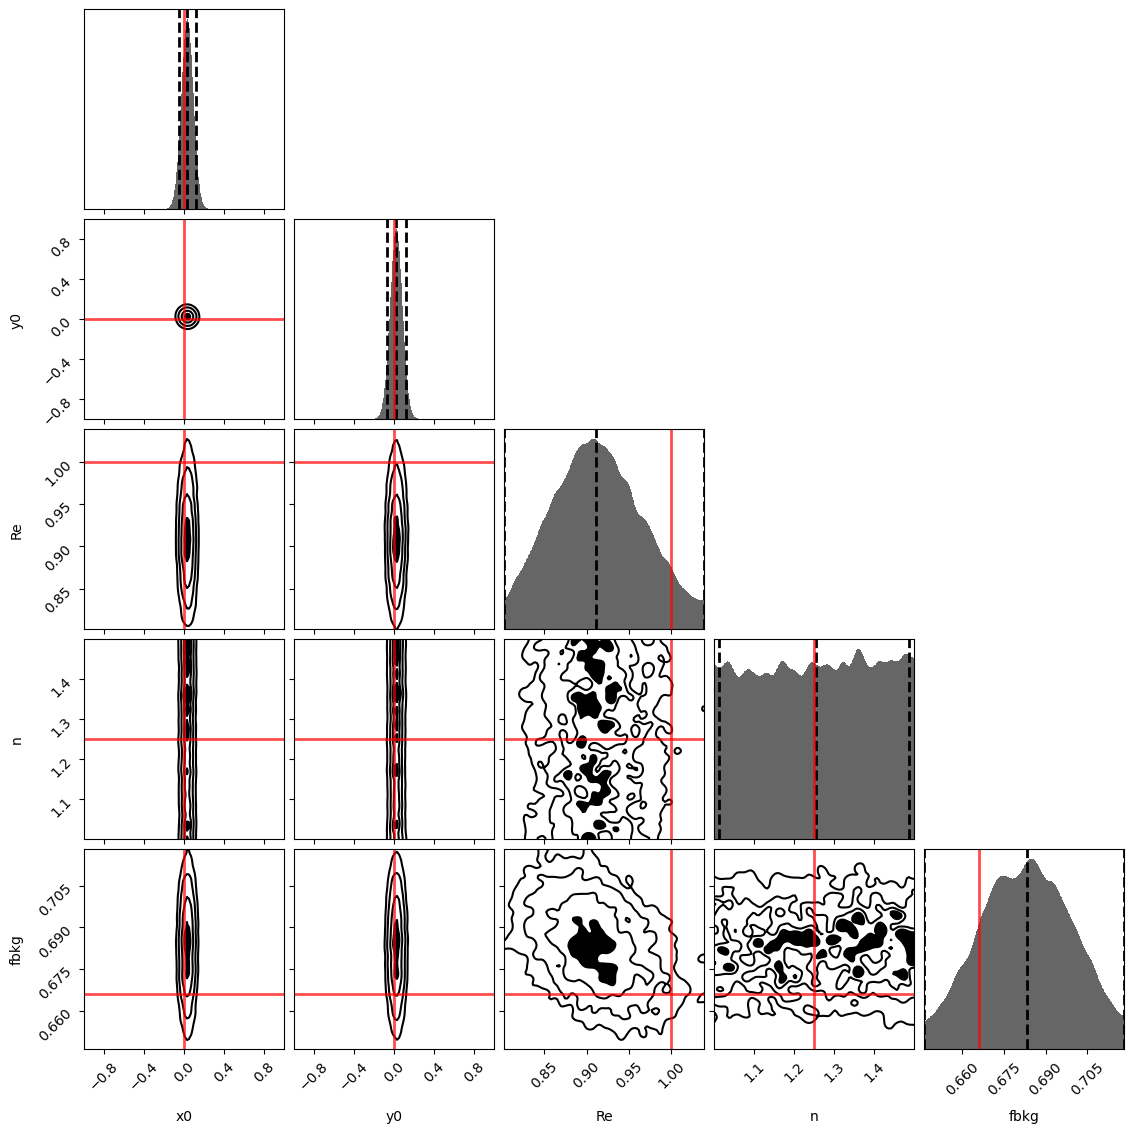

In [58]:
fig, axes = dyplot.cornerplot(dsampler2.results, labels=param_names, truths=truths,span=span)

In [68]:
dsampler.results.logz[-1], dsampler2.results.logz[-1], dsampler.results.logz[-1]-dsampler2.results.logz[-1], (dsampler.results.logz[-1]-dsampler2.results.logz[-1])*np.log10(np.exp(1)), np.exp(dsampler.results.logz[-1]-dsampler2.results.logz[-1])

(np.float64(-3189.354111363457),
 np.float64(-3193.594100109918),
 np.float64(4.239988746461222),
 np.float64(1.8414037159199945),
 np.float64(69.40707075919799))

69 dHarts sersic over exponential.  That's "strong"/"very strong"!

Now lets consider the other kinds of test regions:

In [78]:
results = {}
truths = {}
print('regions to try', all_regions.keys())
for regnm, test_region in all_regions.items():
    print(regnm)
    
    test_data, tg, tb = glx_and_uniform(50, 2, test_region)
    truths[regnm] = truths = [0, 0, 1, 1.25, len(tb[0])/(len(tb[0]) + len(tg[0]))]
    with np.errstate(invalid='ignore'):
        with dynesty.pool.Pool(multiprocessing.cpu_count(), loglike, prior_transform,
                                    logl_kwargs={'data': test_data, 'region':test_region},
                        ) as pool:
            dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                                    ndim=len(param_names),sample='rslice')
            dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})
    results[regnm] = dsampler.results

regions to try dict_keys(['circular_large_reg', 'circular_small_reg', 'rectangular_large_reg', 'rectangular_small_reg', 'offset_poly_region'])
circular_large_reg


17757it [01:13, 242.92it/s, batch: 7 | bound: 12 | nc: 1 | ncall: 643193 | eff(%):  2.676 | loglstar: -3241.377 < -3235.824 < -3236.496 | logz: -3248.495 +/-  0.096 | stop:  0.843]    

circular_small_reg



16984it [01:00, 281.49it/s, batch: 6 | bound: 13 | nc: 1 | ncall: 621279 | eff(%):  2.646 | loglstar: -317.521 < -311.472 < -312.432 | logz: -323.904 +/-  0.099 | stop:  0.866]      


rectangular_large_reg


17179it [01:26, 198.44it/s, batch: 6 | bound: 8 | nc: 1 | ncall: 623025 | eff(%):  2.670 | loglstar: -4226.050 < -4220.446 < -4221.957 | logz: -4233.380 +/-  0.095 | stop:  0.883]     

rectangular_small_reg



16494it [01:19, 207.29it/s, batch: 6 | bound: 8 | nc: 1 | ncall: 597776 | eff(%):  2.668 | loglstar: -430.263 < -424.501 < -426.300 | logz: -436.310 +/-  0.091 | stop:  0.880]       


offset_poly_region


16292it [06:57, 39.02it/s, batch: 6 | bound: 7 | nc: 1 | ncall: 585518 | eff(%):  2.689 | loglstar: -460.340 < -455.061 < -456.538 | logz: -466.814 +/-  0.091 | stop:  0.919]       


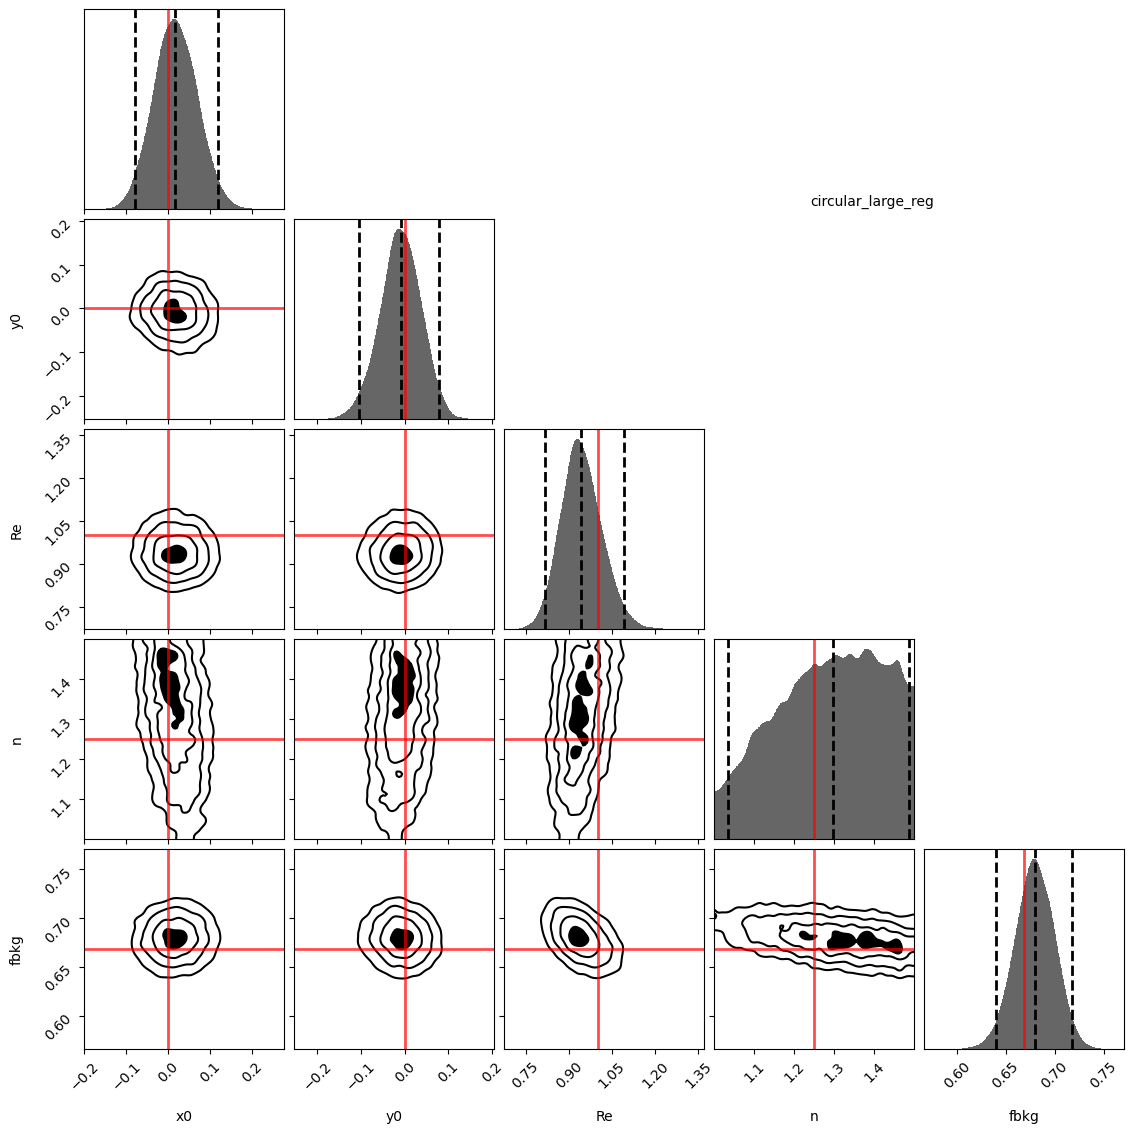

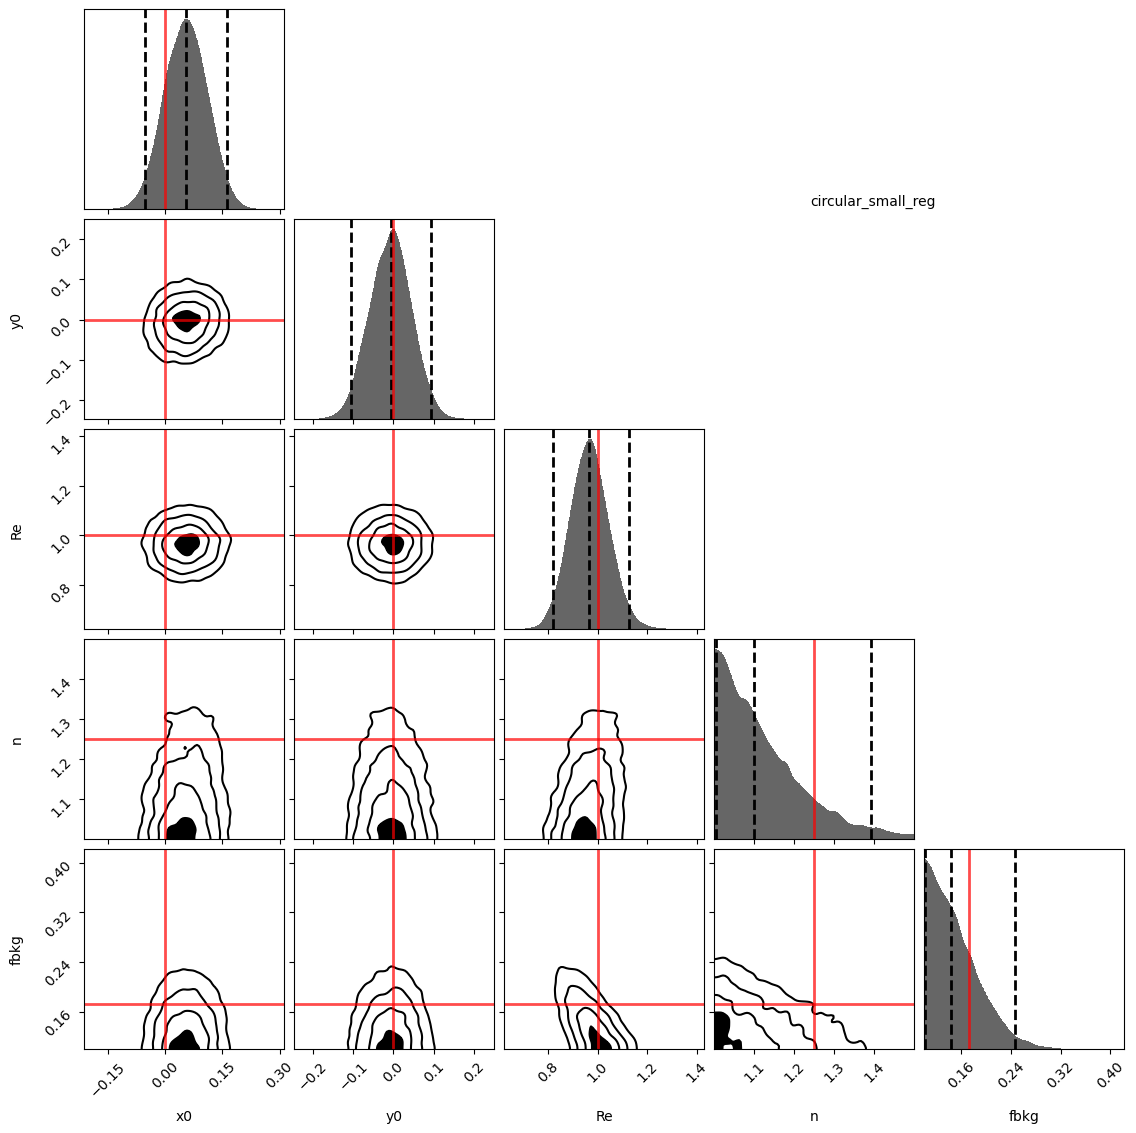

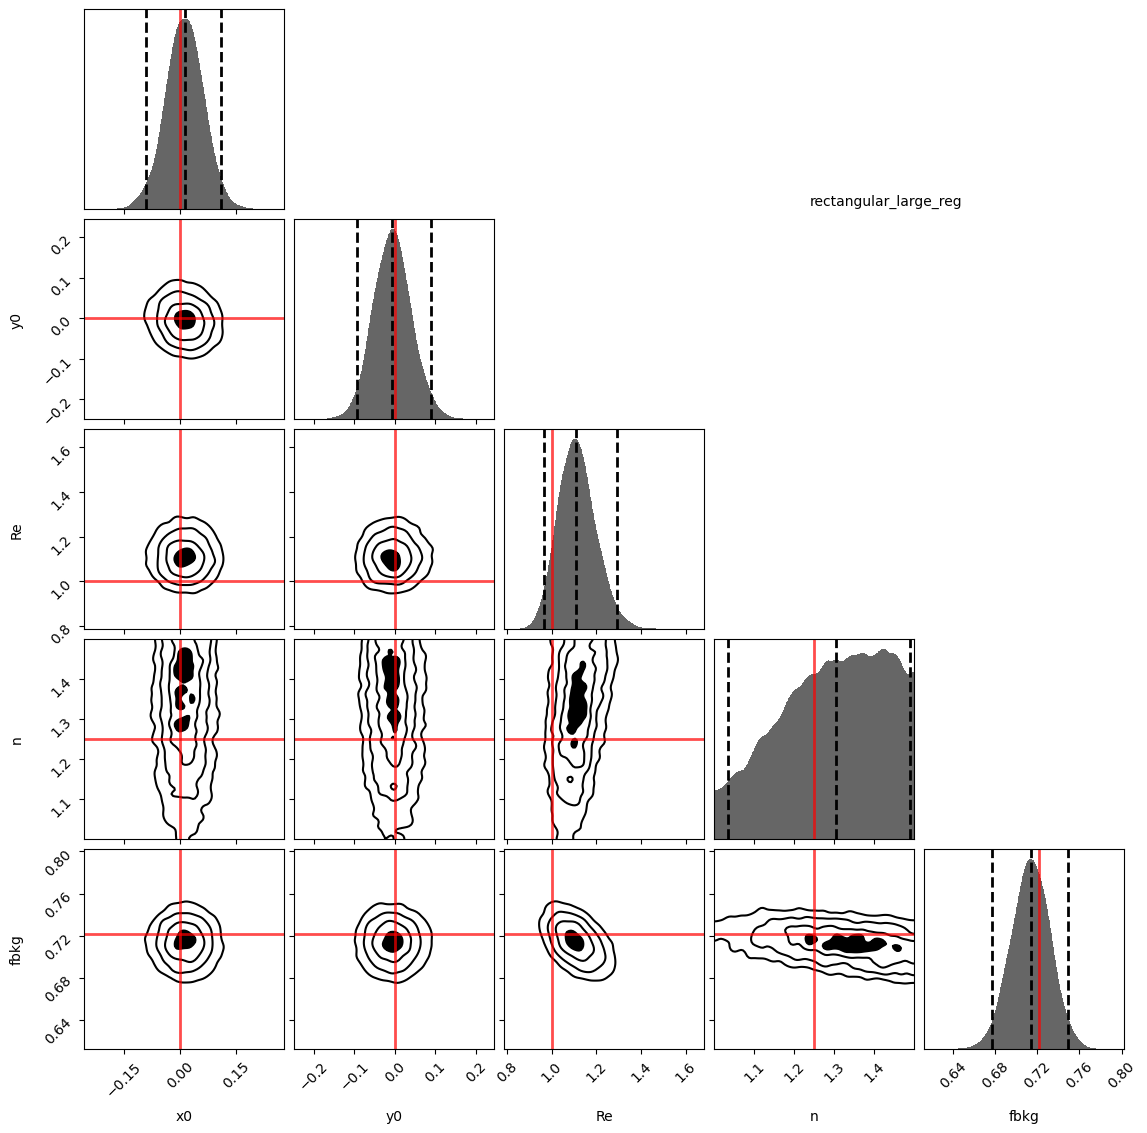

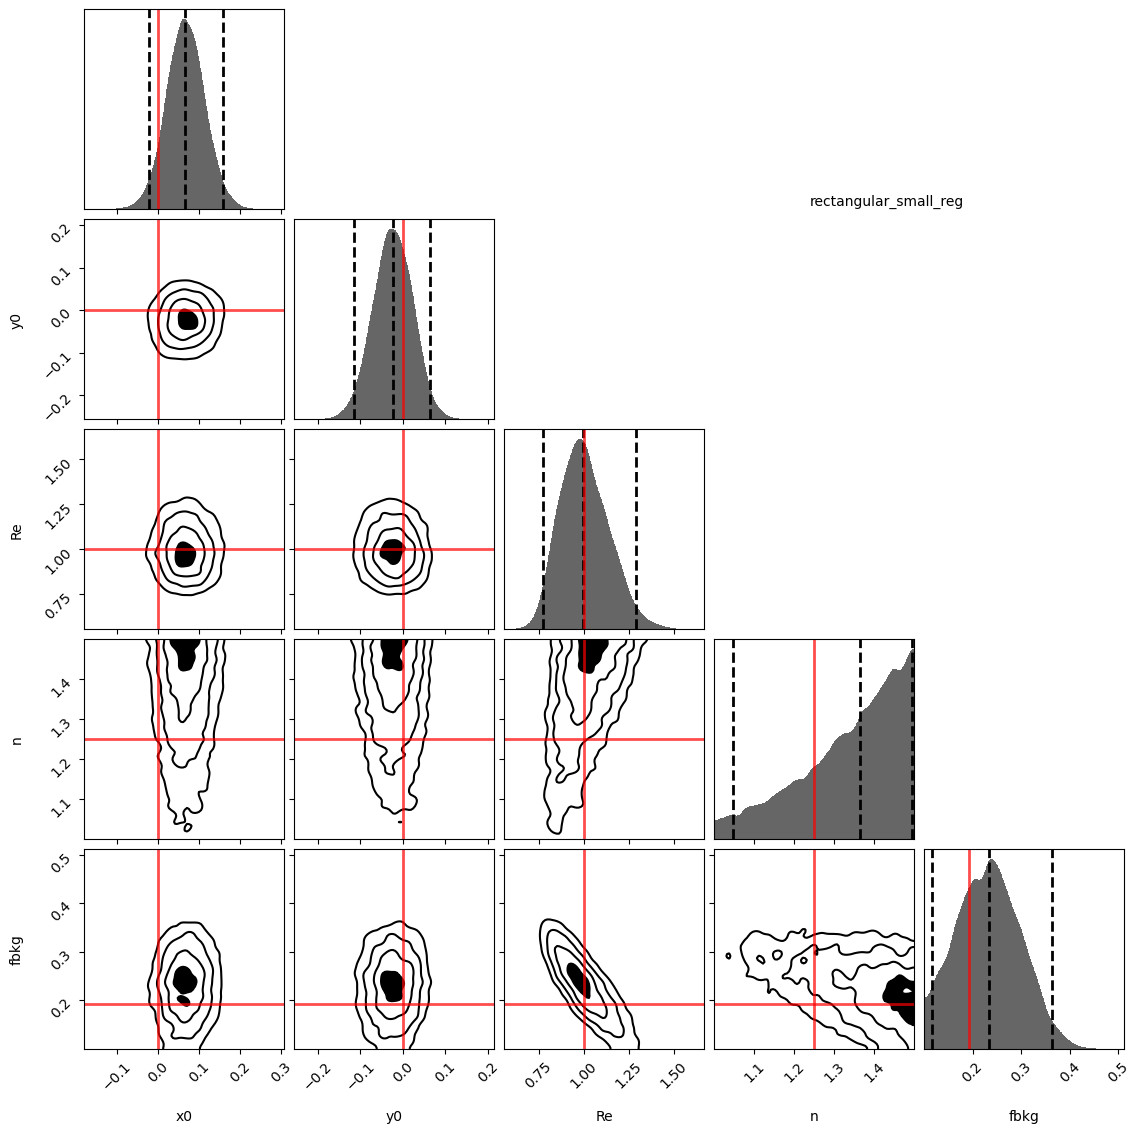

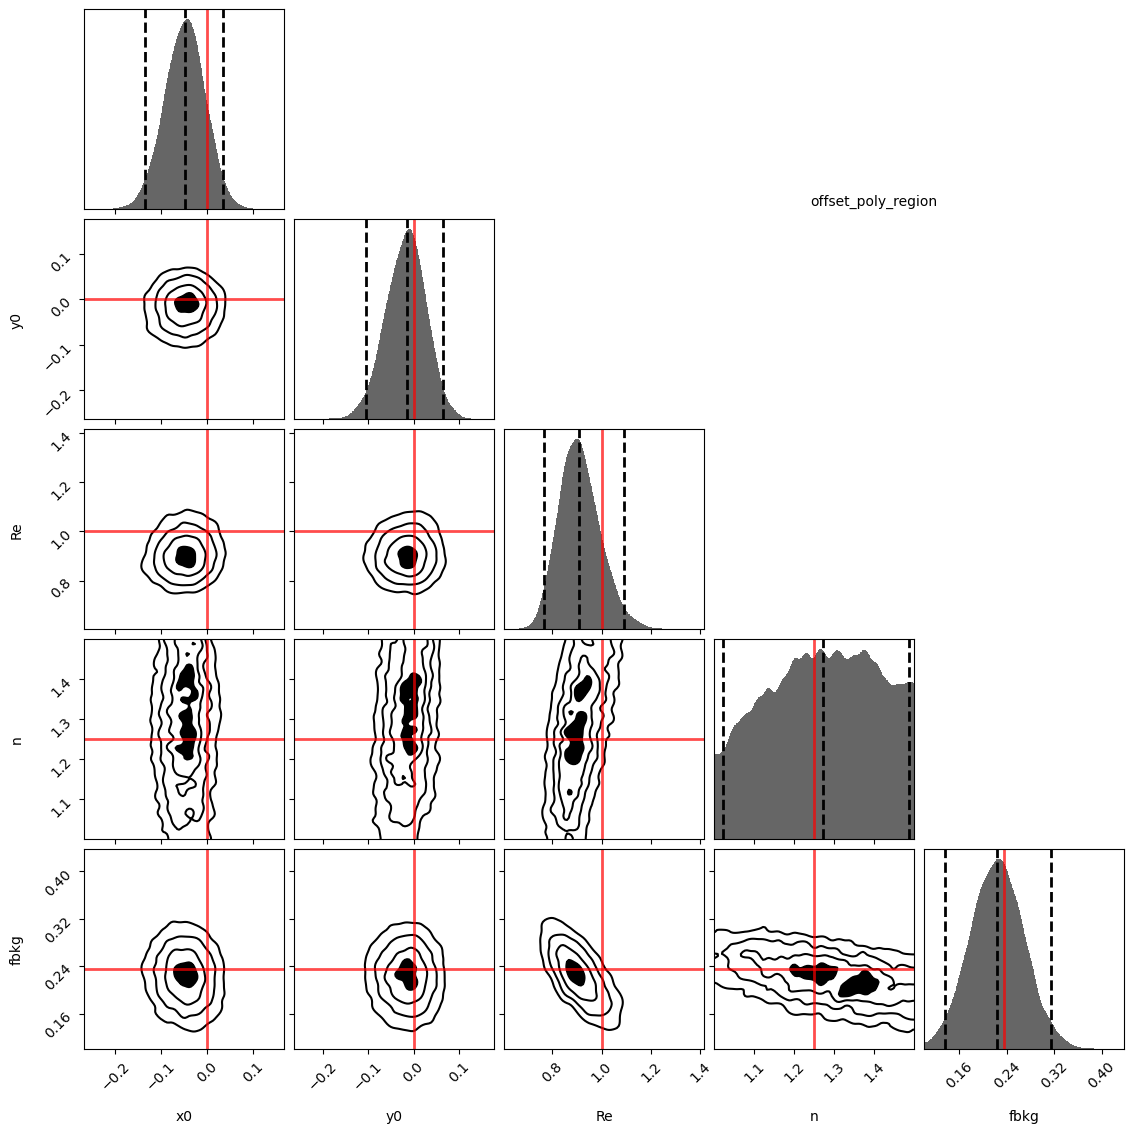

In [92]:
for nm, res in results.items():
    fig, axes = dyplot.cornerplot(res, labels=param_names, truths=truths[nm])
    axes[0][0].text(.7,.8, nm, transform=fig.transFigure)

As expected... things start going a bit nuts for small regions. Add in ellipticality before worrying about solutions.